In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set_style('white')
from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Use device {device}")

Use device cpu


### Generate data

In [2]:
class DataModule():
    def __init__(self, num_observatiosn=2000, batch_size=128, num_workers=2, is_train=True):
        self.N = num_observatiosn
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.is_train = is_train

    def generate_orgin(self, batch_size: int) -> torch.Tensor:
        """Generate original data."""
        raise NotImplementedError

    def _generate_data(self, iterations=3):
        self.origin = self.generate_orgin(self.N)
        d = self.origin.clone()
        w_size = d.shape[1]
        for i in range(iterations):
            W = np.random.uniform(-1, 1, size=(w_size, w_size))
            d = torch.tanh(d @ W)
        self.data = d.to(torch.float32)

    def get_dataloader(self, iterations=3):
        self._generate_data(iterations=iterations)
        return DataLoader((self.data, self.generate_orgin(self.N)), batch_size=self.batch_size, \
                          num_workers=self.num_workers, shuffle=self.is_train)
    
    def show_distribution(self, data: torch.Tensor, nrows: int, ncols: int, fig_path=None):
        assert data.shape[1] == nrows*ncols, "The number of subplots does not match the number of data."
        fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
        axs = axs.reshape((nrows, ncols))
        for r in range(nrows):
            for c in range(ncols):
                idx = r * ncols + c
                sns.histplot(data[:, idx], ax=axs[r, c])
        if fig_path is not None:
            fig.savefig(fig_path)


class Data_dim2(DataModule):
    def __init__(self, num_observatiosn=2000, batch_size=128, num_workers=2, is_train=True):
        super().__init__(num_observatiosn, batch_size, num_workers, is_train)
    
    def generate_orgin(self, batch_size) -> torch.Tensor:
        size = (batch_size, 1)
        d1 = np.random.uniform(-1, 1, size)
        d2 = np.random.exponential(1, size)
        origin = torch.tensor(np.concatenate([d1, d2], axis=1), dtype=torch.float32)
        return origin

### MMD
Can consider use multiple kernels in the MMD-GAN

In [3]:
def rbf_kernel(X, Y, gamma):
    """
    Calculate the RBF kernel of the given data X and Y
    
    Args
    ----
    X, Y: torch.Tensor
        The target data
    gamma: float
        Inverse of the bandwidth (1/sigma)
        
    Returns
    -------
    """
    assert X.shape[1] == Y.shape[1], "The data should have the same dimension."

    # Calculate the Euclidean distance between the every pair of data in X and Y
    K = ((X[: ,np.newaxis, :] - Y[np.newaxis, :, :])**2).sum(axis=2)
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    
    K *= -gamma 
    return torch.exp(K)

def mmd2(X, Y, kernel=rbf_kernel, gamma=10):
    K_xx, K_xy, K_yy = kernel(X, X, gamma), kernel(X, Y, gamma), kernel(Y, Y, gamma)
    n = X.shape[0]
    numerator = n * (n - 1)
    return K_xx.sum() / numerator - (2*K_xy.sum())  / numerator + K_yy.sum() / numerator

def mmd(X, Y, kernel=rbf_kernel, **kwargs):
    return mmd2(X, Y, kernel, **kwargs)**(0.5)

### Network

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, input_size*2),
            nn.ReLU(),
            nn.Linear(input_size*2, input_size*4),
            nn.ReLU(),
            nn.Linear(input_size*4, input_size*2),
            nn.ReLU(),
            nn.Linear(input_size*2, input_size),
        )
    
    def __getitem__(self, idx):
        return self.net[idx]
    
    def forward(self, X):
        return self.net(X)

def weight_init(m: nn.Module):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)

def get_net(input_size):
    net = Encoder(input_size=input_size).to(device)
    net.apply(weight_init)
    return net

### Train

In [9]:
batch_size = 256
data = Data_dim2(num_observatiosn=5000, batch_size=batch_size)
train_loader = data.get_dataloader(3)
num_epochs = 1000
loss = mmd

In [10]:
def train(num_epochs, train_loader, device, loss, net, lr, gamma, wd=0, betas=(0.9, 0.999), fig_path=None, verbose=False):
    # configure optimizer
    optimizer = torch.optim.Adam(net.parameters(), betas=betas,lr=lr, weight_decay=wd)

    loss_list = []
    for epoch in range(num_epochs):
        X, y = data.data.to(device=device), data.generate_orgin(data.N).to(device=device)
        l = loss(net(X), y, gamma=gamma)
        l.backward()
        optimizer.step()
        loss_list.append(l.item())

        if verbose and (epoch + 1) % 10 == 0:
            print(f'[{epoch+1}/{num_epochs}] Loss: {loss_list[-1]}')
    
    fig, ax = plt.subplots()
    sns.lineplot(data=loss_list, ax=ax)
    if fig_path is not None:
        fig.savefig(fig_path)
    return loss_list

[10/500] Loss: 0.762362539768219
[20/500] Loss: 0.6092310547828674
[30/500] Loss: 0.388220876455307
[40/500] Loss: 0.3432787358760834
[50/500] Loss: 0.3206724524497986
[60/500] Loss: 0.24345415830612183
[70/500] Loss: 0.1755509227514267
[80/500] Loss: 0.14071692526340485
[90/500] Loss: 0.12950390577316284
[100/500] Loss: 0.12357432395219803
[110/500] Loss: 0.11764124035835266
[120/500] Loss: 0.11433650553226471
[130/500] Loss: 0.11048382520675659
[140/500] Loss: 0.1064545214176178
[150/500] Loss: 0.10318036377429962
[160/500] Loss: 0.1004638820886612
[170/500] Loss: 0.0982675775885582
[180/500] Loss: 0.09644525498151779
[190/500] Loss: 0.09497629106044769
[200/500] Loss: 0.09378359466791153
[210/500] Loss: 0.09280229359865189
[220/500] Loss: 0.09199819713830948
[230/500] Loss: 0.09132787585258484
[240/500] Loss: 0.09076559543609619
[250/500] Loss: 0.09028913825750351
[260/500] Loss: 0.08988215029239655
[270/500] Loss: 0.08953318744897842
[280/500] Loss: 0.0892343819141388
[290/500] Los

[0.9553183913230896,
 0.9398122429847717,
 0.9238994121551514,
 0.9067592620849609,
 0.8882845044136047,
 0.867916464805603,
 0.8450161814689636,
 0.8194199204444885,
 0.7915431261062622,
 0.762362539768219,
 0.7329719066619873,
 0.7039676308631897,
 0.6764853596687317,
 0.6522409915924072,
 0.6419439911842346,
 0.6423395276069641,
 0.6421398520469666,
 0.6361960172653198,
 0.6248101592063904,
 0.6092310547828674,
 0.5902170538902283,
 0.5684291124343872,
 0.5449112057685852,
 0.5206745862960815,
 0.49684804677963257,
 0.47405871748924255,
 0.4522026777267456,
 0.4305638074874878,
 0.40902653336524963,
 0.388220876455307,
 0.3695874810218811,
 0.3545827269554138,
 0.34418243169784546,
 0.3375129997730255,
 0.33347541093826294,
 0.3316355347633362,
 0.33213678002357483,
 0.33460018038749695,
 0.3387613892555237,
 0.3432787358760834,
 0.34762436151504517,
 0.35133570432662964,
 0.35490745306015015,
 0.35807308554649353,
 0.3588297665119171,
 0.3549765944480896,
 0.3473845422267914,
 0.33

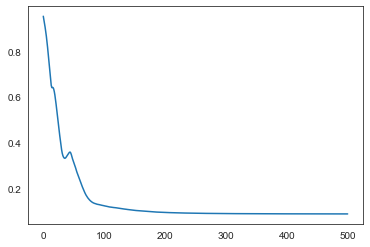

In [13]:
net = get_net(data.data.shape[1])
train(500, train_loader, device, loss, net, lr=1e-2, gamma=100, verbose=True)

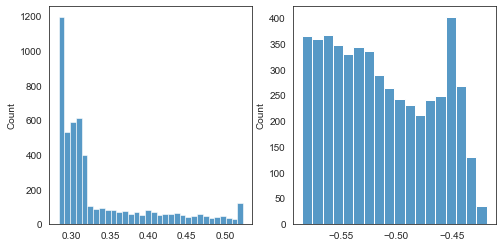

In [19]:
with torch.no_grad():
    y = net(data.data)
data.show_distribution(y, 1, 2)

In [14]:
gammas = [1, 10, 100, 1000]
lrs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
for lr in lrs:
    for gamma in gammas:
        net = get_net(data.data.shape[1])
        train()

TypeError: train() missing 7 required positional arguments: 'num_epochs', 'train_loader', 'device', 'loss', 'net', 'lr', and 'gamma'

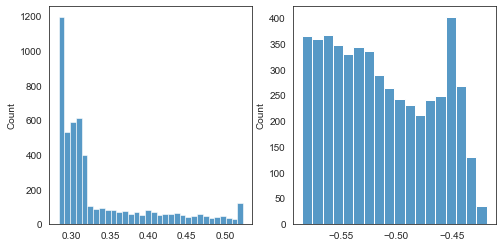

In [ ]:
# The hyper parameter to be adjusted
gammas = [1, 10, 100, 1000]
lrs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]   

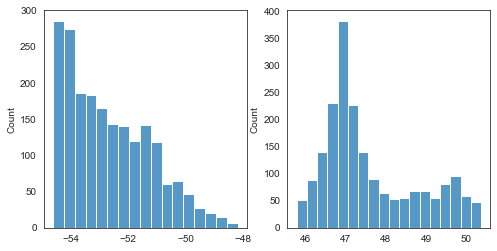

In [ ]:
data.show_distribution(y.cpu(), 1, 2, fig_path='test.png')

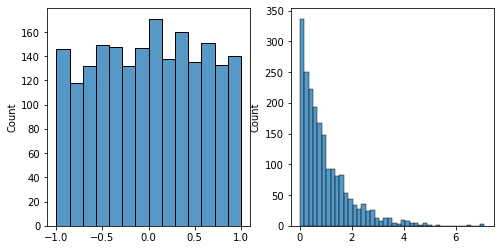

In [ ]:
data.show_distribution(data.origin, 1, 2)

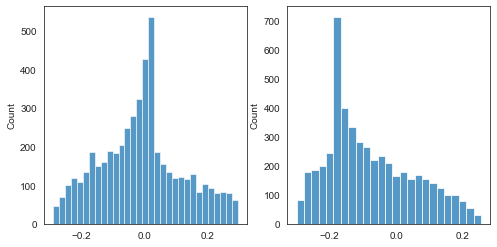

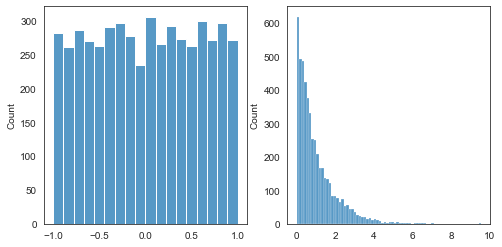

In [ ]:
for X, y in train_loader:
    data.show_distribution(X, 1, 2)
    data.show_distribution(y, 1, 2)
    break